## LINEAR MODELS
Compare values of hemispheres to structural values

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from functools import reduce

In [30]:
# Load the csv
base_dir_linux =  f'/home/extop/GERARD/DATA/MAGNIMS2021/'
base_dir_win = f'C:/Users/gerar/Documents/graph_values/'

csv_cc = f'{base_dir_win}/cc.csv'
csv_hemis = f'{base_dir_win}/graph_intrainter_cort_G_SC.csv'
csv_hemis_nodes = f'{base_dir_win}/graph_nodes_SC.csv'
csv_total = f'{base_dir_win}/data_total.csv'
extracted_values_path  = f'{base_dir_win}/extracted_values.csv'

df_cc = pd.read_csv(csv_cc)
df_hemis = pd.read_csv(csv_hemis)
df_extracted = pd.read_csv(extracted_values_path)
df_hemis_nodes = pd.read_csv(csv_hemis_nodes)
df_total = pd.read_csv(csv_total)

In [31]:
# merge results and total
data_frames = [df_total, df_cc, df_hemis, df_extracted]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=["SubjID", "CENTER"]), data_frames)

df_merged = df_merged[df_merged.QC == "Y"]

len(df_merged)
df_merged['disease'] = np.where(df_merged['GROUP']=='HC', "HC", "MS")

df_merged["Full_hemis"] = ( df_merged["SC_L_avg_spl"] + df_merged["SC_R_avg_spl"] ) / 2

df_merged["Full_CC"] = df_merged["CC_Posterior"] + df_merged["CC_Mid_Posterior"] + df_merged["CC_Central"] + df_merged["CC_Mid_Anterior"] + df_merged["CC_Anterior"]
df_merged["Comm_ratio_approx"] = ( df_merged["CC_Posterior"] + df_merged["CC_Mid_Posterior"] + df_merged["CC_Central"] + df_merged["CC_Mid_Anterior"] + df_merged["CC_Anterior"] ) / df_merged["EstimatedTotalIntraCranialVol"]
df_merged["CC_ratio_area"] = np.sqrt(df_merged["CC_Sag_area"]) / (df_merged["BrainSegVol"]**(1./3.))
df_merged["CC_Sag_area_sqrt"] = np.log10(np.sqrt(df_merged["CC_Sag_area"]))
df_merged["TIV_cubicroot"] = np.log10(df_merged["BrainSegVol"]**(1./3.))


In [32]:
print(len(df_merged))

725


c:\Users\gerar\Anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


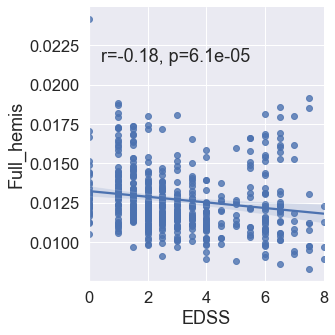

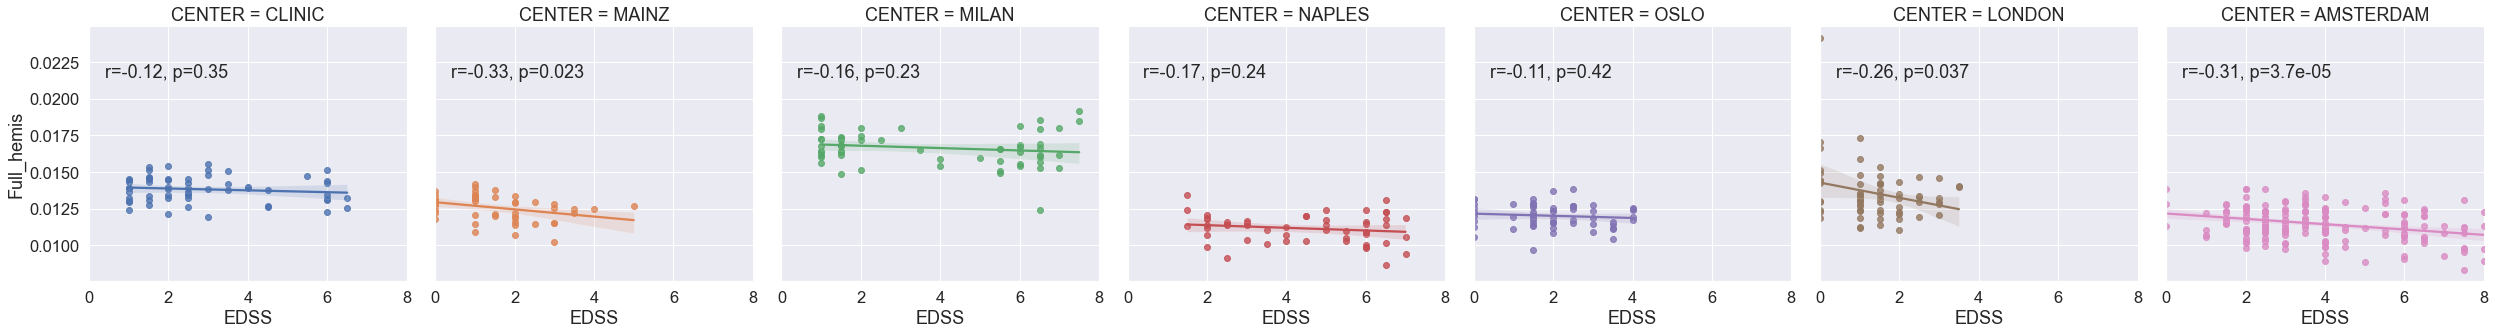

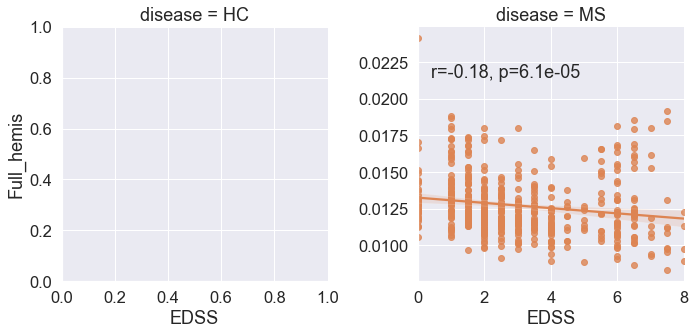

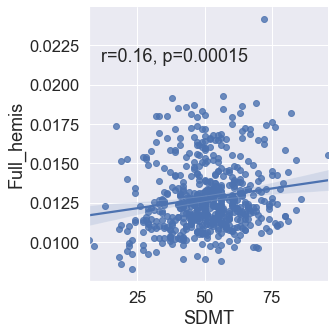

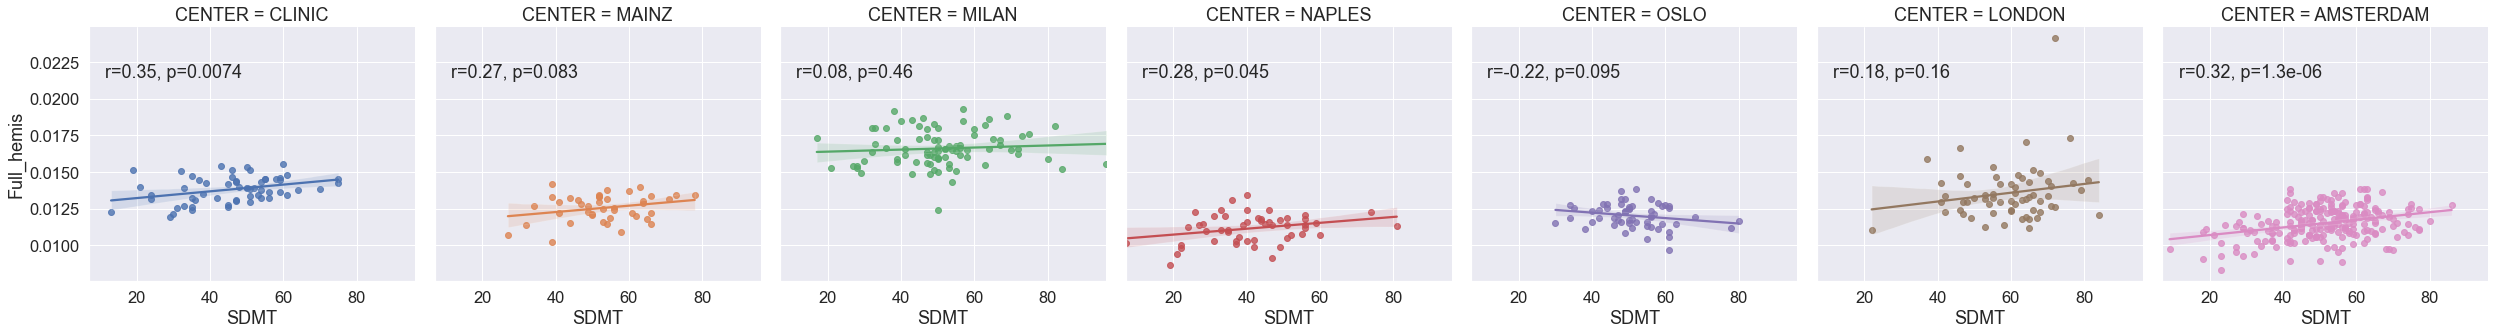

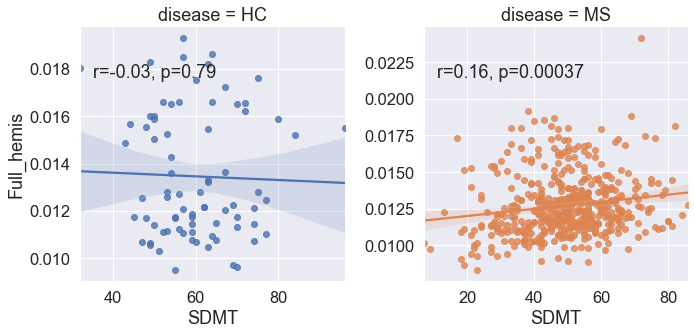

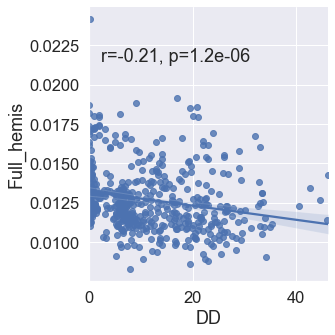

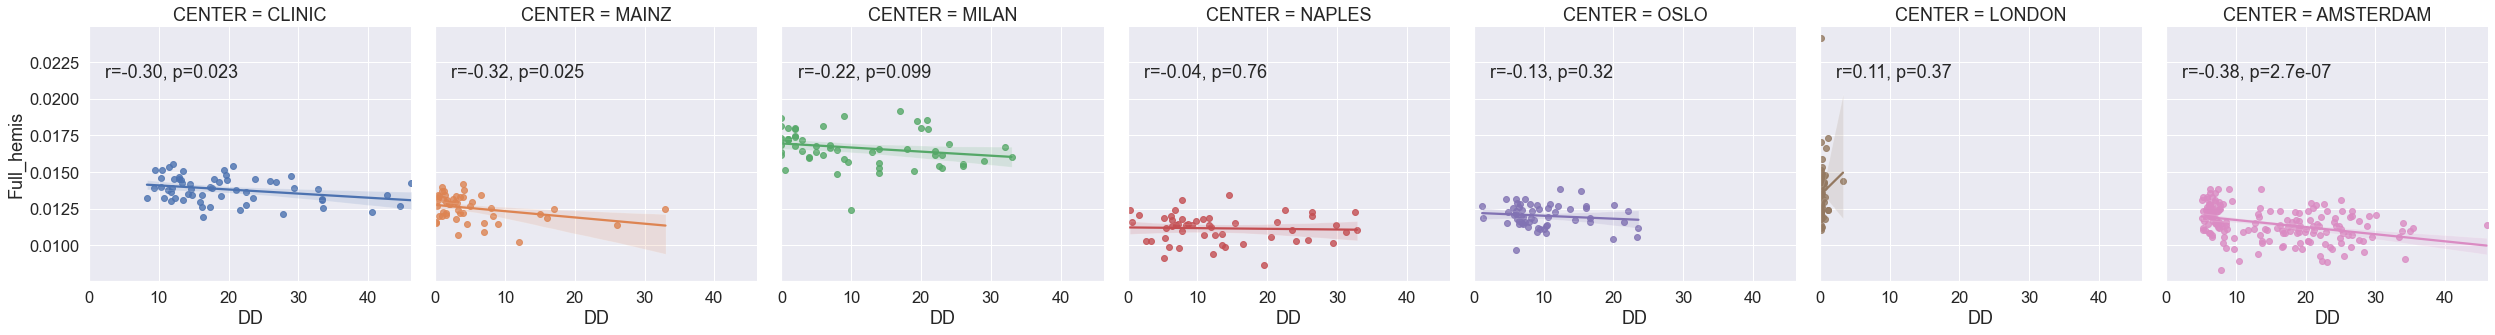

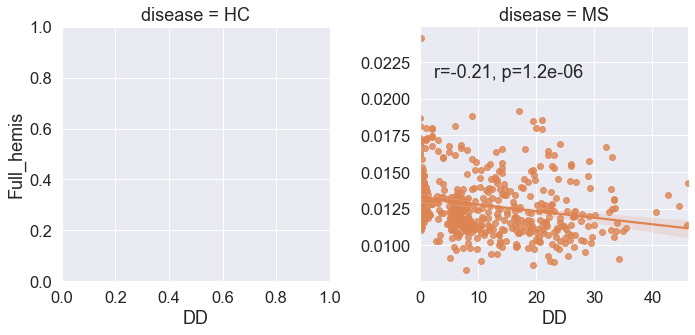

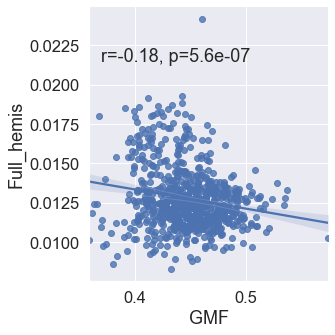

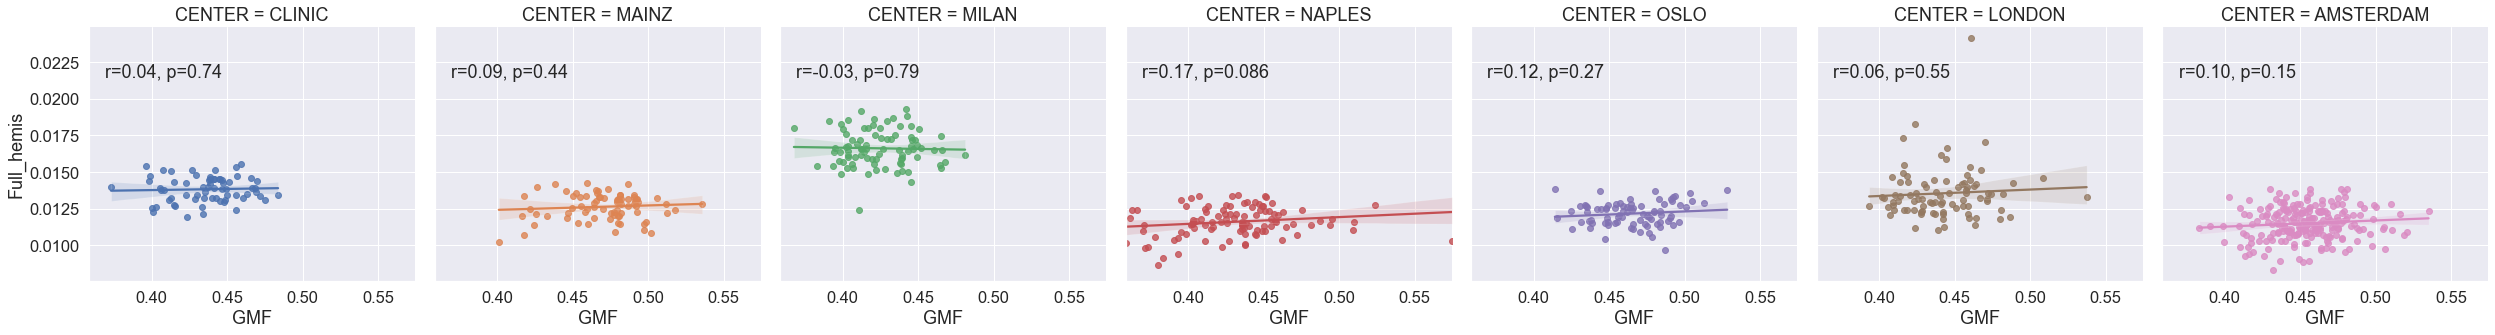

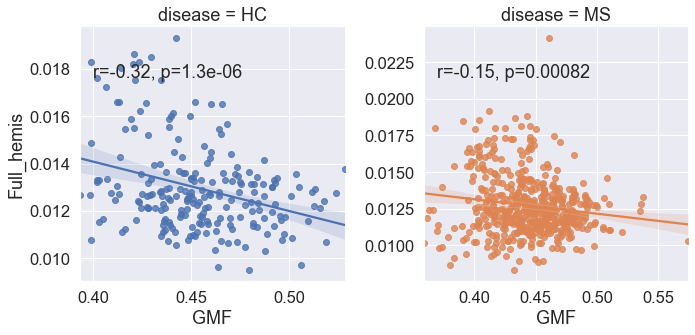

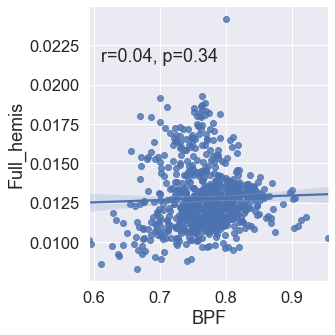

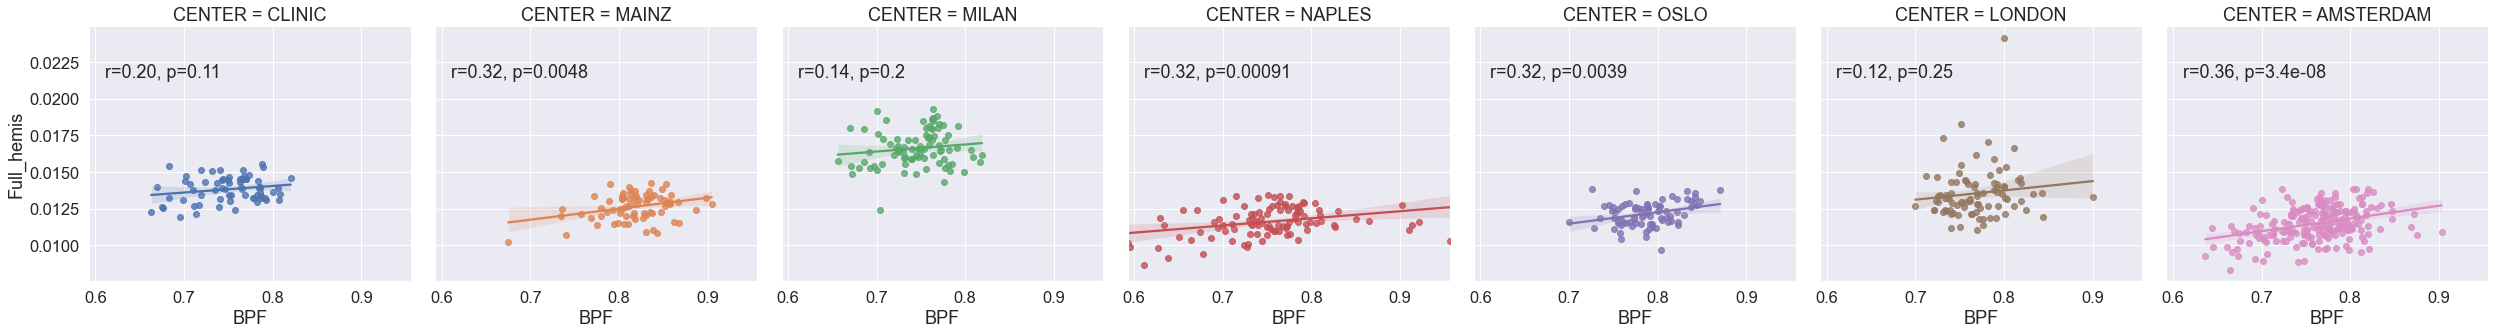

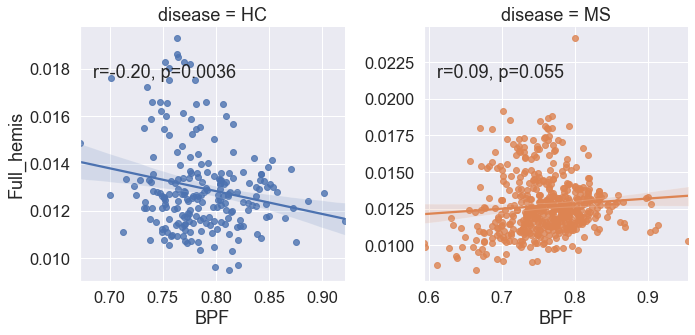

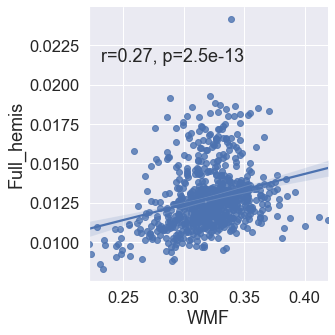

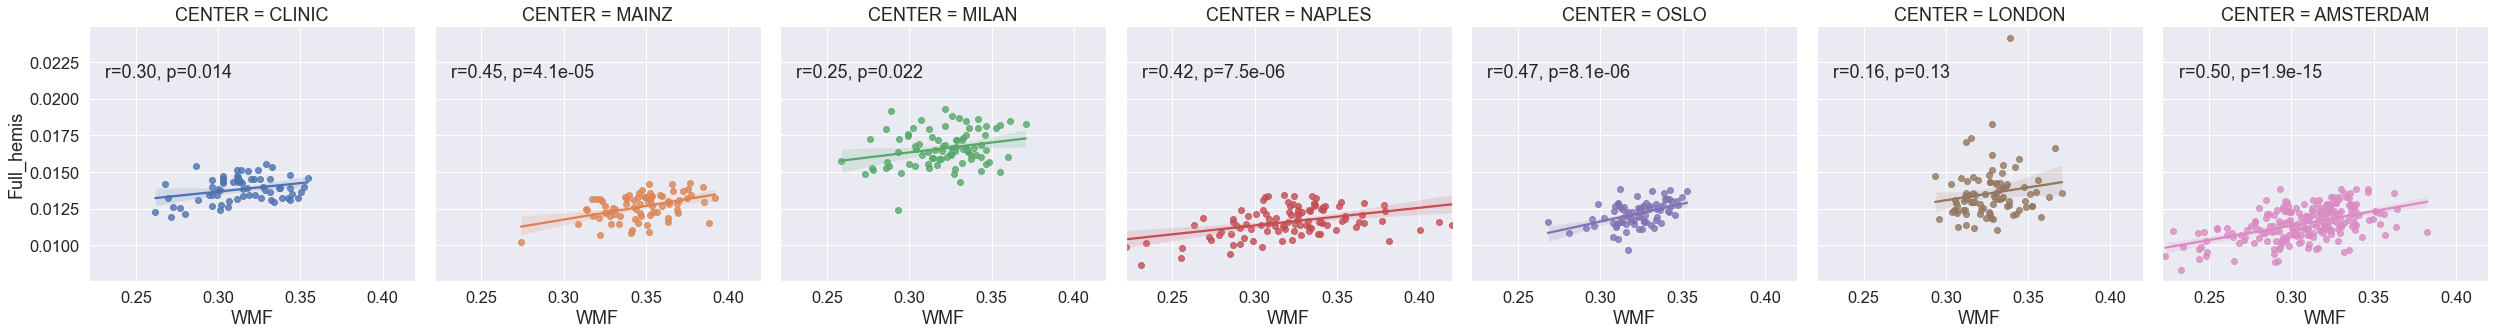

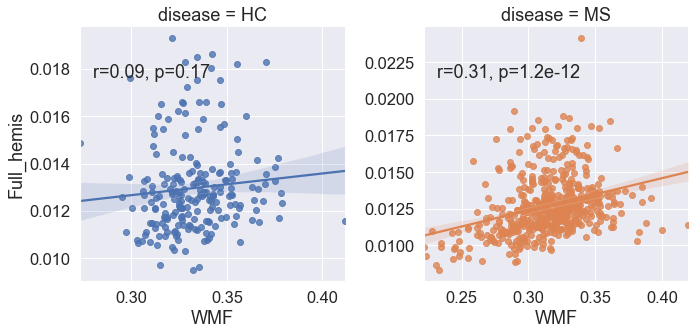

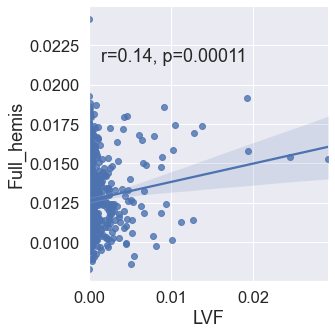

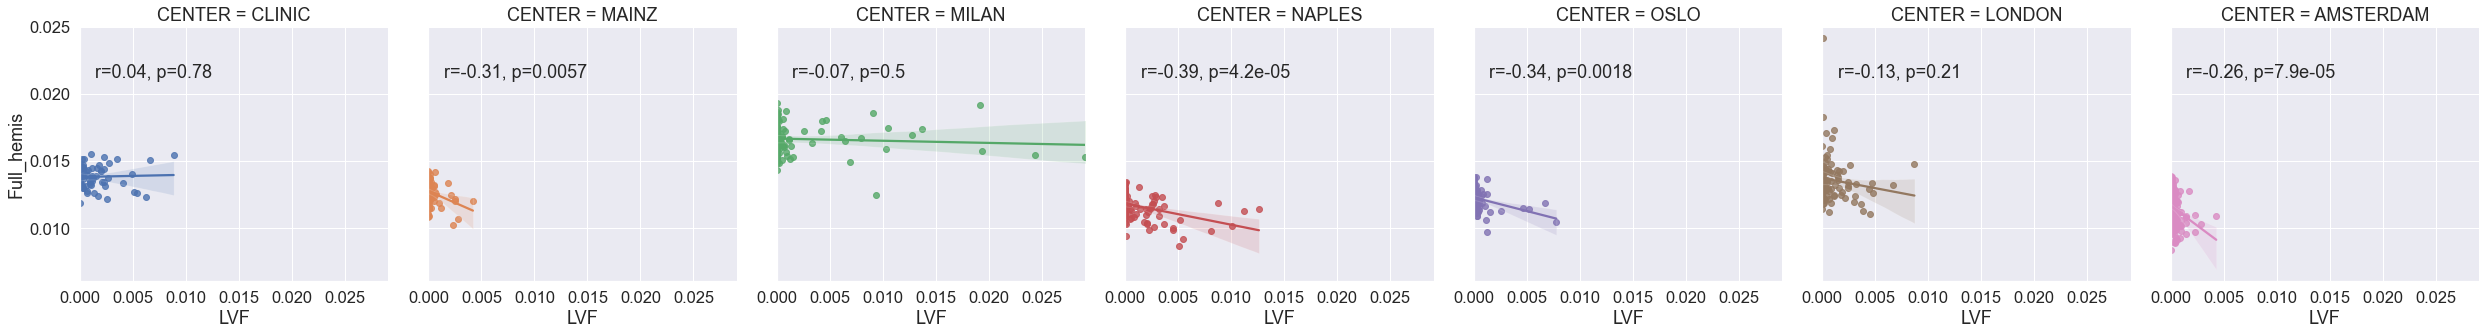

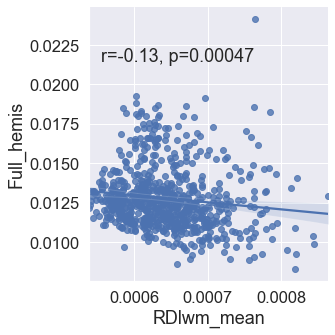

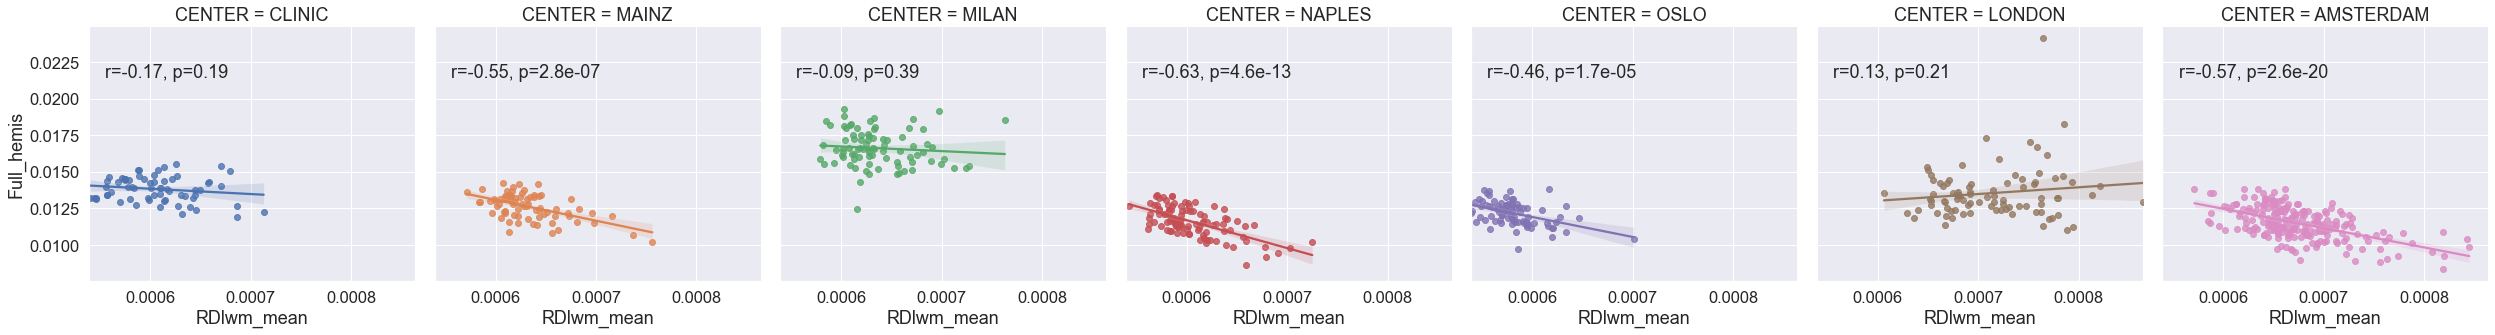

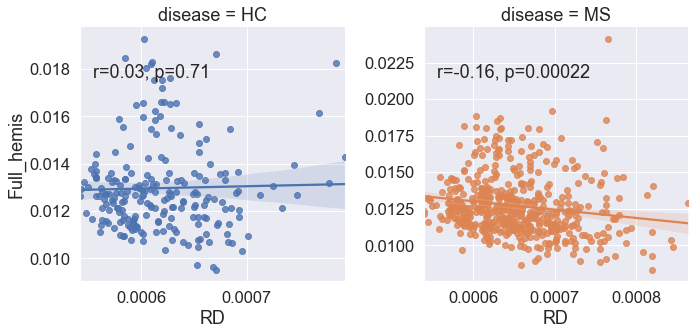

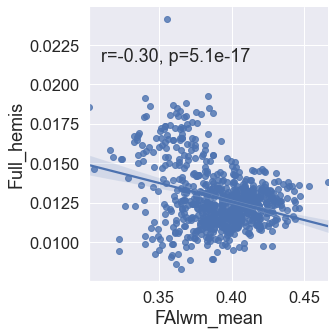

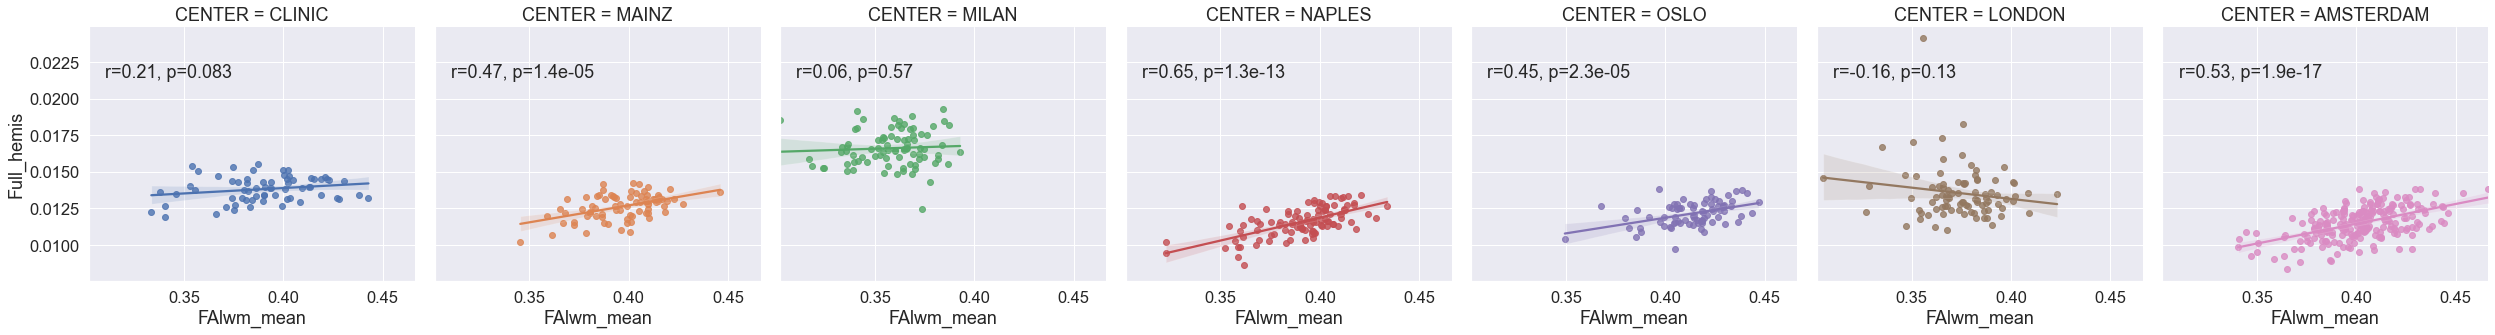

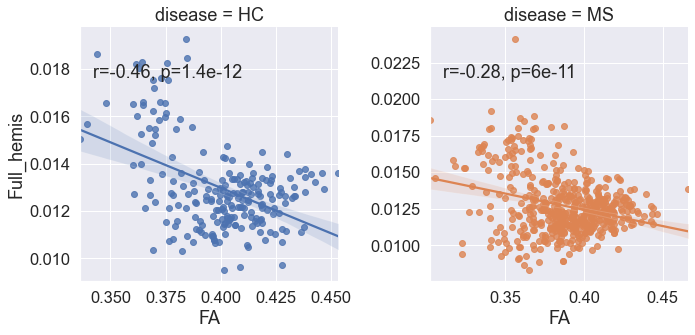

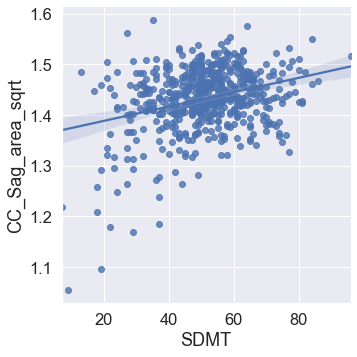

In [42]:
"""
ANALYSIS of the data
Biomarkers to analyze:

Full_CC
Comm_ratio_approx
CC_ratio_area
Full_hemis

Explicar que és cada variable?  
"""
### Scatterplot G
## Compare different values 

from scipy import stats
sns.set_style("darkgrid")
varx = "dummy"
vary = "Full_hemis"

def annotate(data, **kws):
    r, p = stats.pearsonr(data[f"{varx}"], data[f"{vary}"])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

variables = ["EDSS", "SDMT", "DD", "GMF", "BPF", "WMF", "LVF", "RDlwm_mean", "FAlwm_mean"]
sns.set(font_scale = 1.5)

for varx in variables:
    # AGE
    if varx in ["DD", "SDMT", "EDSS"]:
        data_to_plot = df_merged.dropna(subset=[varx])
    
    elif varx == "LVF":
        data_to_plot = df_merged.dropna(subset=[varx])
        data_to_plot = data_to_plot[data_to_plot.LVF < 1.0]
    else:
        data_to_plot = df_merged
    g = sns.lmplot(data=data_to_plot, x=f"{varx}", y=f"{vary}")
    g.map_dataframe(annotate)
    g.set_axis_labels(varx, vary)
    plt.tight_layout()
    
    g = sns.lmplot(data=data_to_plot, x=f"{varx}", y=f"{vary}", col="CENTER", hue="CENTER")
    g.map_dataframe(annotate)
    g.set_axis_labels(varx, vary)
    plt.tight_layout()

    if varx in ["DD", "SDMT", "EDSS", "GMF", "BPF", "WMF", "RDlwm_mean", "FAlwm_mean"]:
        g = sns.lmplot(data=data_to_plot, x=f"{varx}", y=f"{vary}", col="disease", hue="disease", hue_order=["HC", "MS"], col_order=["HC", "MS"], sharex=False, sharey=False)
        g.map_dataframe(annotate)
        g.set_axis_labels(varx, vary)
        plt.tight_layout()
    
    if varx == "RDwm_mean" or varx == "RDlwm_mean": g.set_xlabels("RD")
    if varx == "FAlwm_mean": g.set_xlabels("FA")


In [41]:
"""
Full_CC
Comm_ratio_approx
CC_ratio_area
Full_hemis
"""

structural_dmg_vars = ["BPF", "GMF", "WMF", "LVF", "RDwm_mean", "FAwm_mean"]
df_results_glm = pd.DataFrame()
dependent_vars = ["EDSS", "SDMT"]
variable_to_test_for = "Full_hemis"
type_of_model = "glm" # "logit" or "glm"

for biomarker in structural_dmg_vars:
    
    results_to_save = {}
    for xvar in dependent_vars:
        df_figure = df_merged.dropna(subset=[biomarker])

        #normalize between 0 and 1 the values of the biomarker
        if type_of_model == "logit":
            df_figure[dependent_vars] = (df_figure[dependent_vars] - df_figure[dependent_vars].min()) / (df_figure[dependent_vars].max() - df_figure[dependent_vars].min())

        formula = f'{xvar} ~ {variable_to_test_for} + {biomarker} + AGE + C(SEX) + C(CENTER2)' 

        if type_of_model == "logit":
            results = smf.logit(formula, data=df_figure).fit()
        elif type_of_model == "glm":
            results = smf.ols(formula, data=df_figure).fit()
        else: results = "NA"
        tstat = results.tvalues[variable_to_test_for] # tstat value for the test, biomarker
        pval = results.pvalues[variable_to_test_for] # pval for the test, bimoarker
        str_save = f"t={tstat:.3f}, p={pval:.3f}"

        results_to_save[xvar] = str_save

    df_results_glm = df_results_glm.append({'Biomarker': biomarker, 'EDSS': results_to_save["EDSS"], 'SDMT': results_to_save["SDMT"]}, ignore_index=True)

# remove index from df
df_results_glm = df_results_glm.reset_index(drop=True)
display(df_results_glm)


,Biomarker,EDSS,SDMT
0,BPF,"t=-2.047, p=0.041","t=2.981, p=0.003"
1,GMF,"t=-3.021, p=0.003","t=4.187, p=0.000"
2,WMF,"t=-1.845, p=0.066","t=1.769, p=0.077"
3,LVF,"t=-2.900, p=0.004","t=3.947, p=0.000"
4,RDwm_mean,"t=-1.312, p=0.190","t=1.723, p=0.085"
5,FAwm_mean,"t=-1.764, p=0.078","t=2.433, p=0.015"
